In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 30
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1992-04-15', datetime.date(2022, 4, 16))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


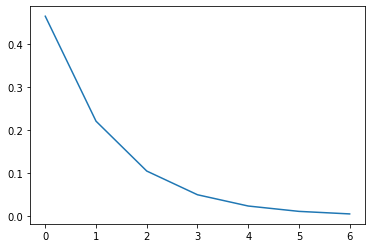

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.005368709120000003

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-08  19.043186  7.402860  19.043186  7.402860  19.043186  7.402860   
2022-04-11  18.852863  7.262342  18.852863  7.262342  18.852863  7.262342   
2022-04-12  18.689837  7.176103  18.689837  7.176103  18.689837  7.176103   
2022-04-13  19.243916  7.359597  19.243916  7.359597  19.243916  7.359597   
2022-04-14  18.657302  7.120408  18.657302  7.120408  18.657302  7.120408   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-08  19.043186  7.402860  19.043186  7.402860  
2022-04-11  18.852863  7.262342  18.852863  7.262342  
2022-04-12  18.689837  7.176103  18.689837  7.176103  
2022-04-13  19.243916  7.359597  19.243916  7.359597  
2022-04-14  18.657302  7.120408  18.657302  7.120408

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                             Close              \
        ^GSPC       ^IXIC         ^NYA       ^W5000       ^GSPC       ^IXIC   
0  416.279999  600.030029  2422.969971  4044.239990  416.279999  600.030029   
1  416.040009  591.809998  2420.330078  4033.340088  416.040009  591.809998   
2  410.179993  577.200012  2387.229980  3972.070068  410.179993  577.200012   
3  410.260010  575.049988  2386.489990  3969.649902  410.260010  575.049988   
4  409.809998  578.229980  2383.530029  3965.780029  409.809998  578.229980   

                                   High              ... DayToDayChange  \
          ^NYA       ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
0  2422.969971  4044.239990  416.279999  600.609985  ...            NaN   
1  2420.330078  4033.340088  416.279999  600.210022  ...       0.997305   
2  2387.229980  3972.070068  416.049988  590.690002  ...       0.984809   
3  2386.489990  3969.649902  411.089996  579.039978  ...       0.999391   
4  2383.530029  3965.780029  411.299988  579.130005  ...       0.999025   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  \
           ^W5000    mine1          mine1          mine1           mine1   
0             NaN      NaN            NaN            NaN             NaN   
1        0.997305      NaN            NaN            NaN             NaN   
2        0.984809      NaN            NaN            NaN             NaN   
3        0.999391      NaN            NaN            NaN             NaN   
4        0.999025      NaN            NaN            NaN             NaN   

  LogValue IntradayChange DayToDayChange OvernightChange  
     mine2          mine2          mine2           mine2  
0      NaN            NaN            NaN             NaN  
1      NaN            NaN            NaN             NaN  
2      NaN            NaN            NaN             NaN  
3      NaN            NaN            NaN             NaN  
4      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

7552   2022-04-08
7553   2022-04-11
7554   2022-04-12
7555   2022-04-13
7556   2022-04-14
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                             Close  \
                 ^GSPC       ^IXIC         ^NYA       ^W5000       ^GSPC   
Date                                                                       
1992-04-15  416.279999  600.030029  2422.969971  4044.239990  416.279999   
1992-04-16  416.040009  591.809998  2420.330078  4033.340088  416.040009   
1992-04-20  410.179993  577.200012  2387.229980  3972.070068  410.179993   
1992-04-21  410.260010  575.049988  2386.489990  3969.649902  410.260010   
1992-04-22  409.809998  578.229980  2383.530029  3965.780029  409.809998   

                                                        High              ...  \
                 ^IXIC         ^NYA       ^W5000       ^GSPC       ^IXIC  ...   
Date                                                                      ...   
1992-04-15  600.030029  2422.969971  4044.239990  416.279999  600.609985  ...   
1992-04-16  591.809998  2420.330078  4033.340088  416.279999  600.210022  ...   
1992-04-20  577.200012  2387.229980  3972.070068  416.049988  590.690002  ...   
1992-04-21  575.049988  2386.489990  3969.649902  411.089996  579.039978  ...   
1992-04-22  578.229980  2383.530029  3965.780029  411.299988  579.130005  ...   

           DayToDayChange OvernightChange LogValue IntradayChange  \
                   ^W5000          ^W5000    mine1          mine1   
Date                                                                
1992-04-15            NaN             NaN      NaN            NaN   
1992-04-16       0.997305        0.997305      NaN            NaN   
1992-04-20       0.984809        0.984809      NaN            NaN   
1992-04-21       0.999391        0.999391      NaN            NaN   
1992-04-22       0.999025        0.999025      NaN            NaN   

           DayToDayChange OvernightChange LogValue IntradayChange  \
                    mine1           mine1    mine2          mine2   
Date                                                                
1992-04-15            NaN             NaN      NaN            NaN   
1992-04-16            NaN             NaN      NaN            NaN   
1992-04-20            NaN             NaN      NaN            NaN   
1992-04-21            NaN             NaN      NaN            NaN   
1992-04-22            NaN             NaN      NaN            NaN   

           DayToDayChange OvernightChange  
                    mine2           mine2  
Date                                       
1992-04-15            NaN             NaN  
1992-04-16            NaN             NaN  
1992-04-20            NaN             NaN  
1992-04-21            NaN             NaN  
1992-04-22            NaN             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.2213282



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.987282482098885
Refitting current best...
Current best ma returns: 4.884744469567397
Fraction Invested: 0.9999981291953925
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 4.884749077993391
Invested: 0.9999989411191972
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.987282482098885
Refitting current best...
Current best ew_ma returns: 5.159179122429339
Fraction Invested: 0.9999999027474755
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 5.159188380865252
Invested: 0.9999999027474755
New best: 5.159246521773782
Invested: 0.9999999027474755
New best: 5.1592468

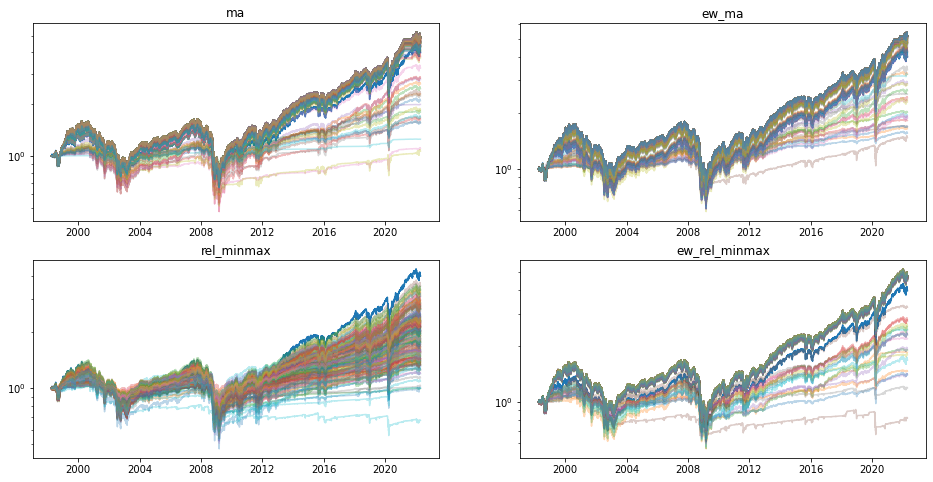

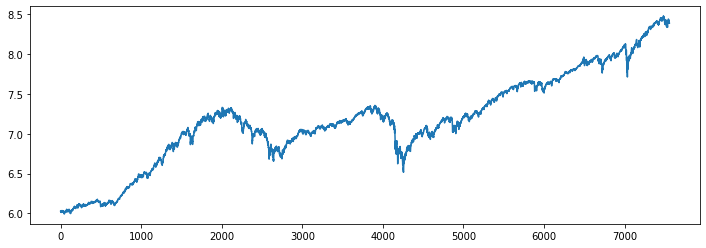

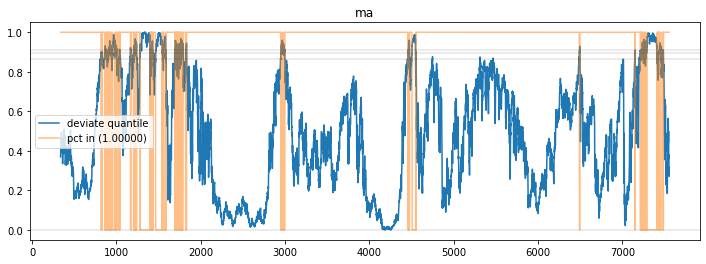

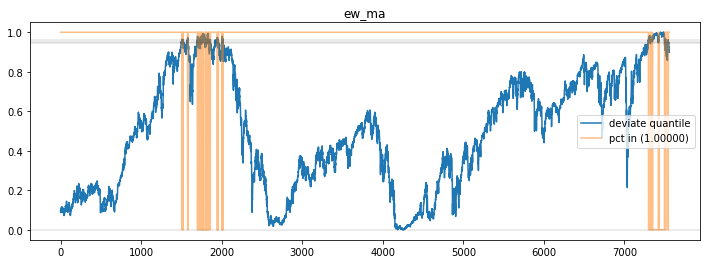

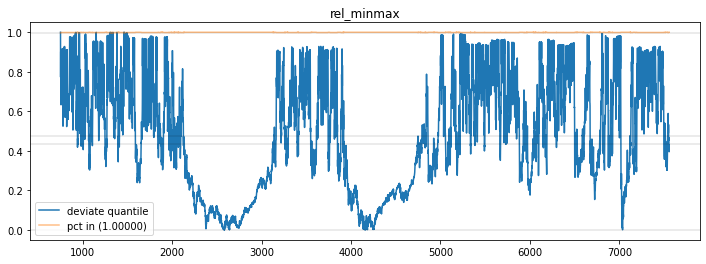

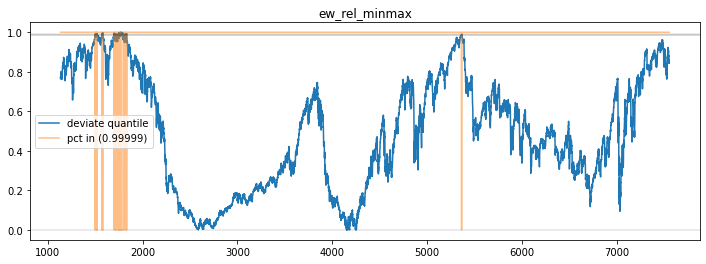

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.3884925960408365
Refitting current best...
Current best ma returns: 9.303978001934238
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 9.304018179270393
Invested: 1.0
New best: 9.500363169676929
Invested: 1.0
New best: 9.52433720102107
Invested: 1.0
New best: 9.524526276480449
Invested: 1.0
New best: 9.524562976369717
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.3884925960408365
Refitting current best...
Current best ew_ma returns: 9.883306236767302
Fraction Invested: 0.9999968886980083
Beginning random search...
Round: 20
Beginning adju

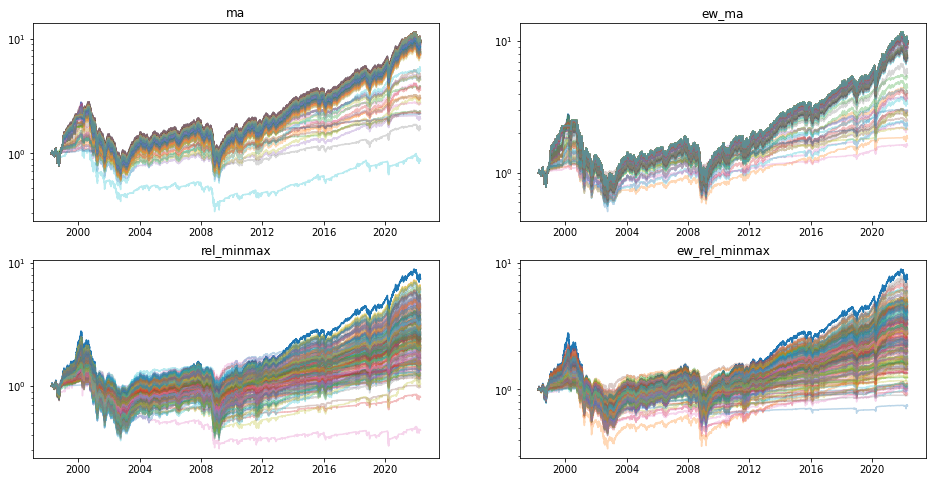

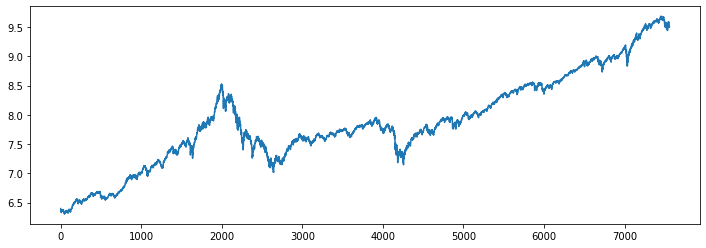

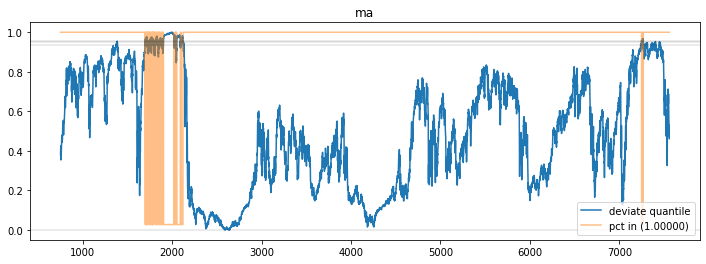

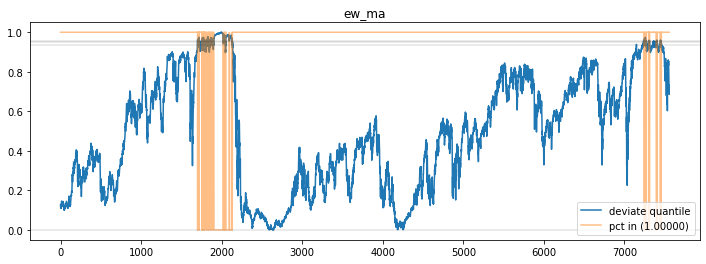

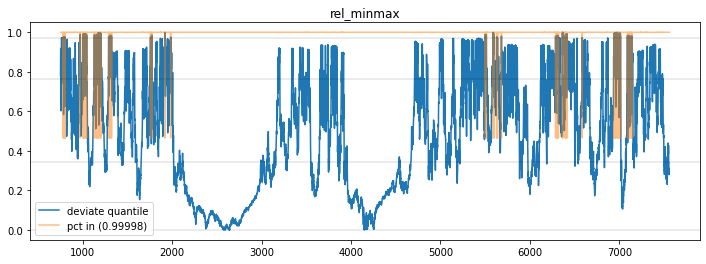

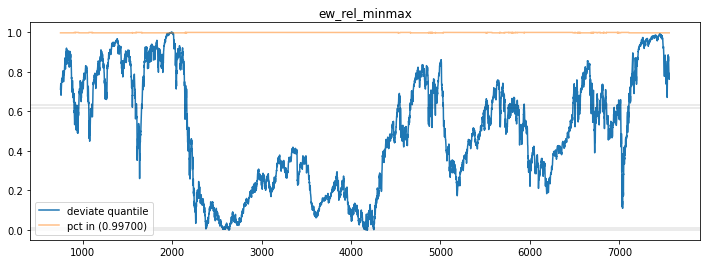

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.722003502361941
Refitting current best...
Current best ma returns: 4.141838131049234
Fraction Invested: 0.9999896398080735
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 4.141838161556805
Invested: 0.9999896398080735
New best: 4.1418438820708365
Invested: 0.9999896398080735
New best: 4.141849710847022
Invested: 0.9999896398080735
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.722003502361941
Refitting current best...
Current best ew_ma returns: 4.4769340838981835
Fraction Invested: 0.9999946474653372
Beginning random search...
Round: 20
Beginning adjusted search...
New best:

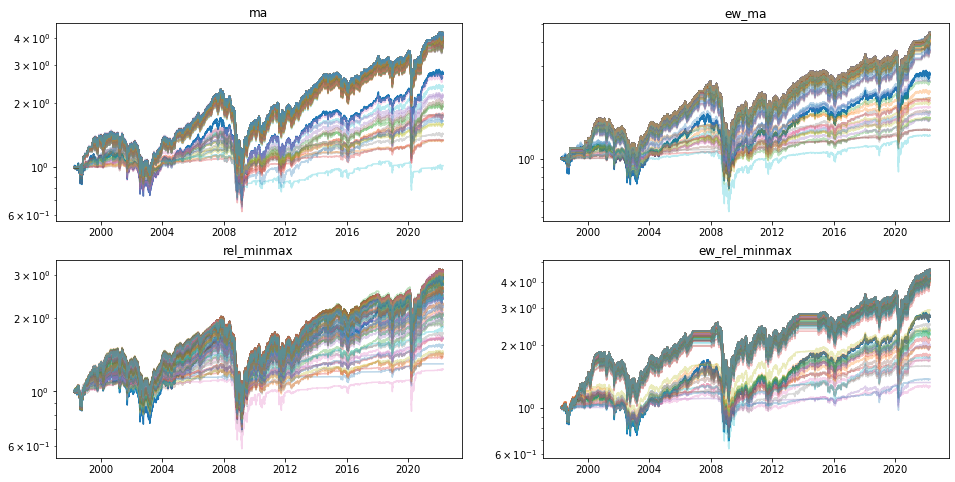

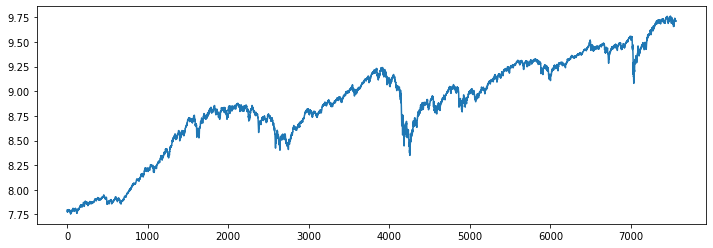

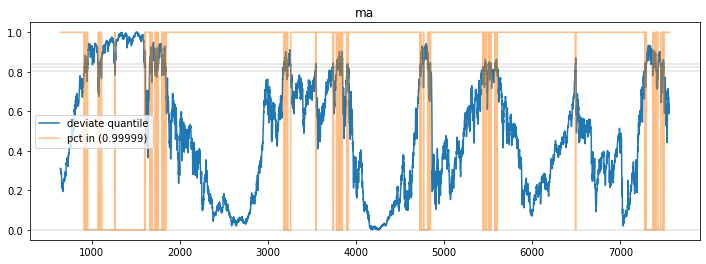

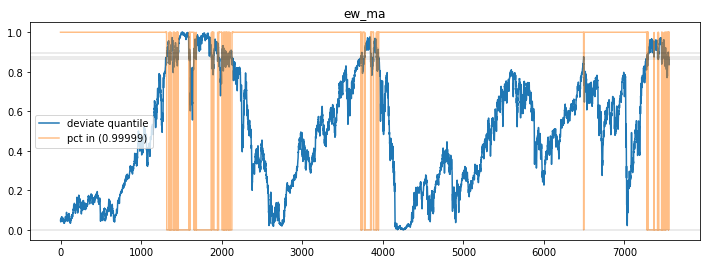

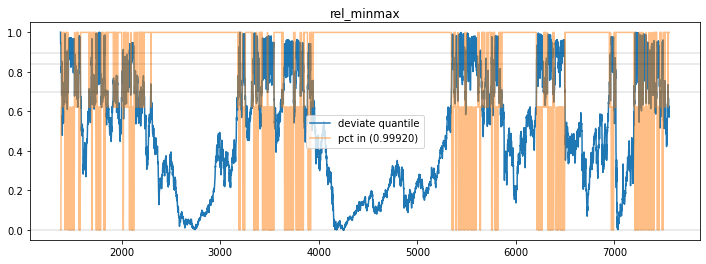

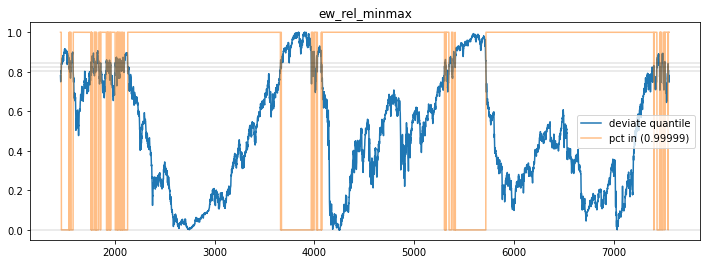

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.213028736773753
Refitting current best...
Current best ma returns: 6.066744954685759
Fraction Invested: 0.9999983611812381
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.213028736773753
Refitting current best...
Current best ew_ma returns: 6.286241266056673
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 6.287597358139803
Invested: 1.0
New best: 6.3465807995207735
Invested: 1.0
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing retur

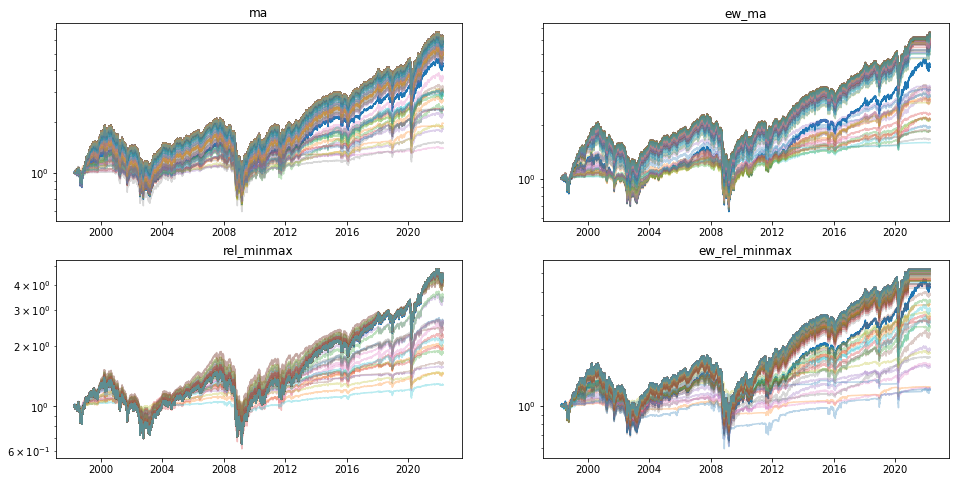

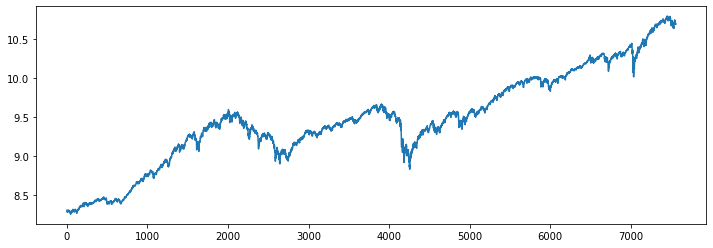

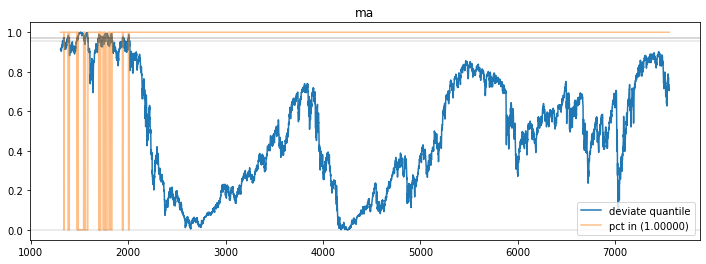

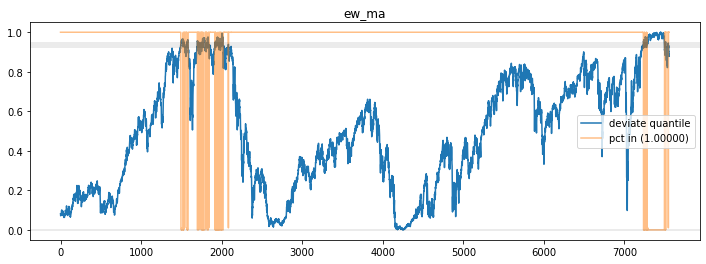

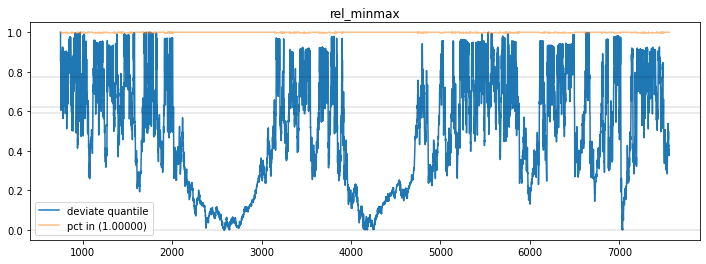

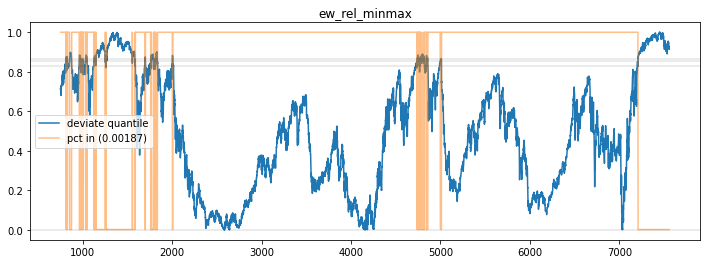

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ma returns: 14.287325303035528
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ew_ma returns: 15.139095988334374
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Fraction Invested: 1
Beginning random search..

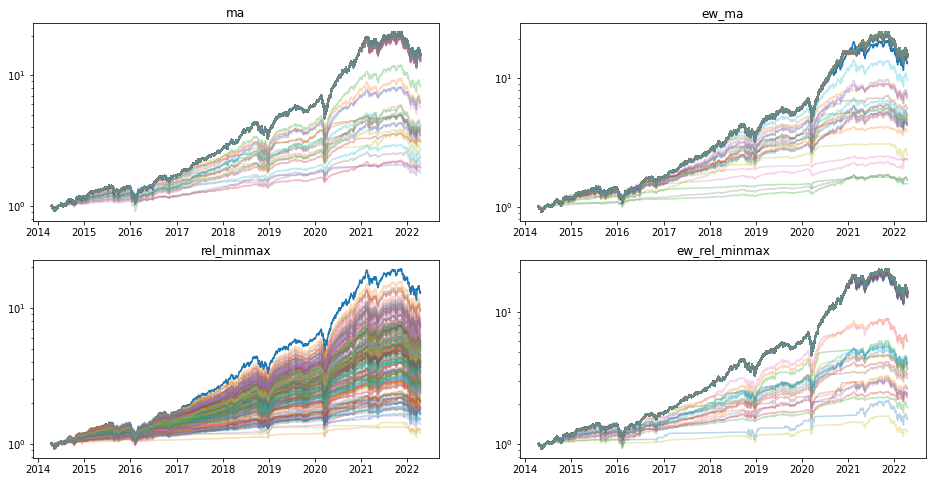

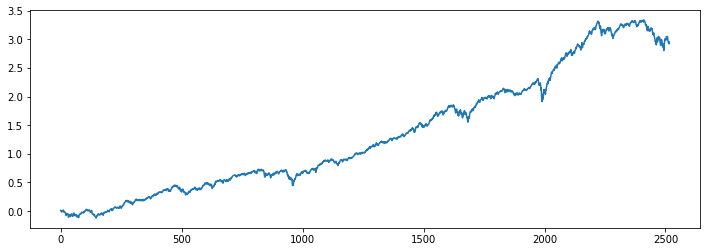

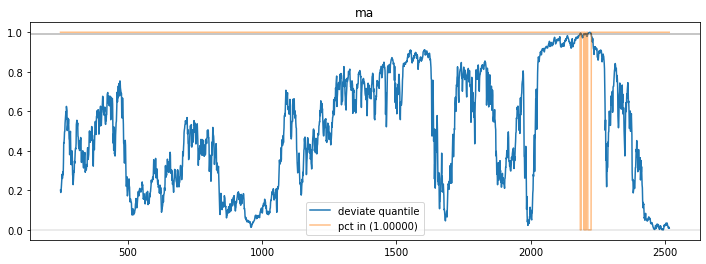

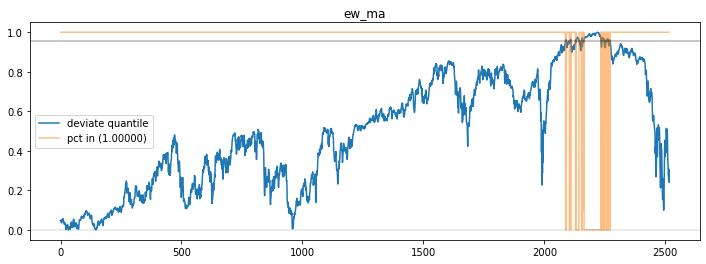

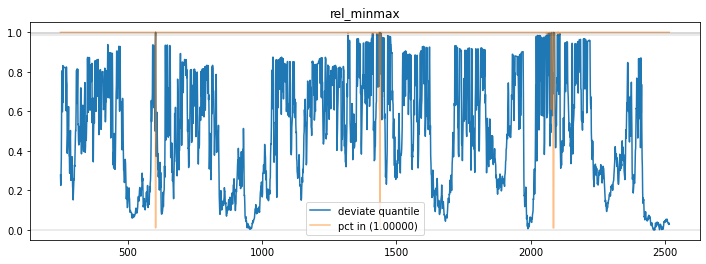

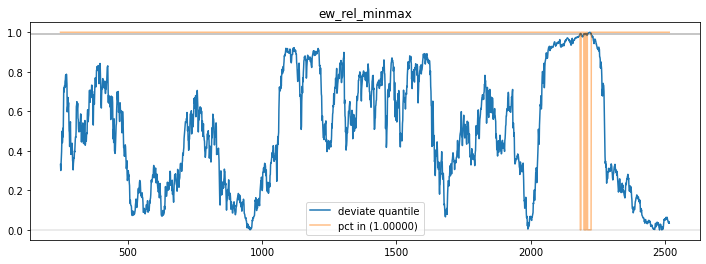

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ma returns: 6.491294238022652
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ew_ma returns: 6.455355637005487
Fraction Invested: 0.9999764342584916
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Fraction Invested: 1
Beginning random

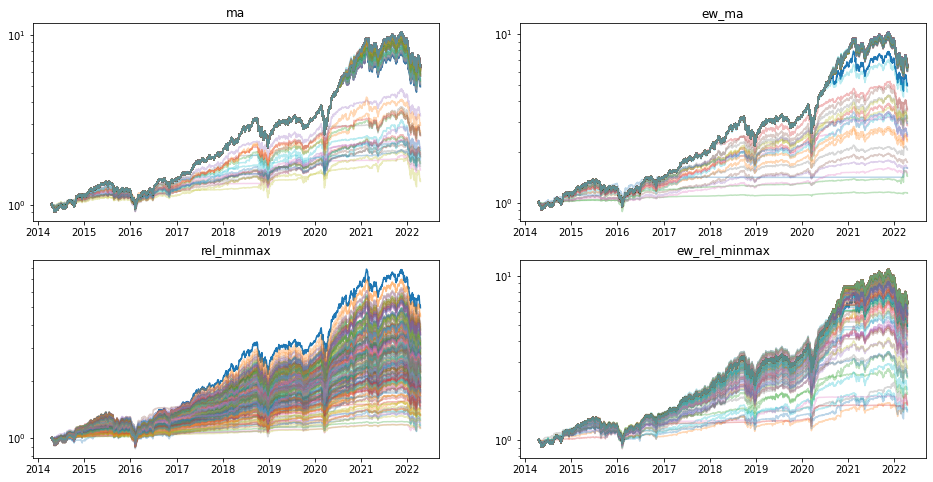

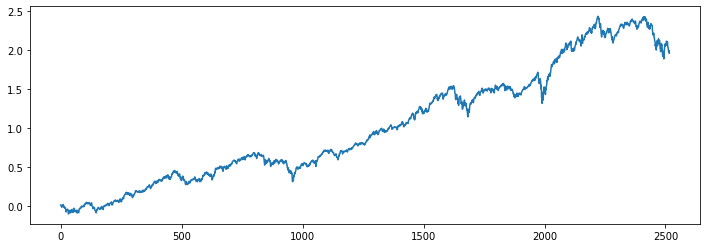

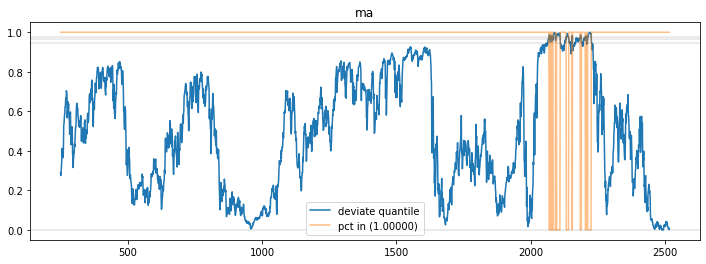

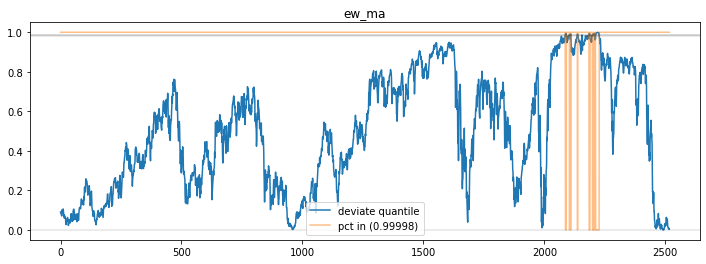

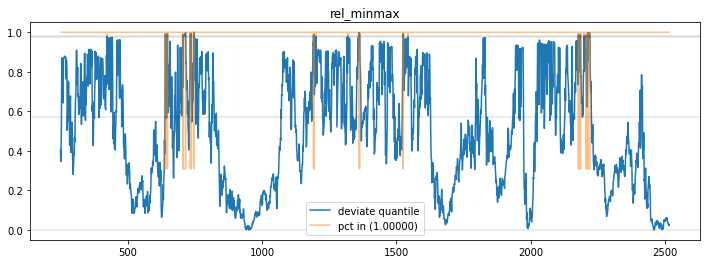

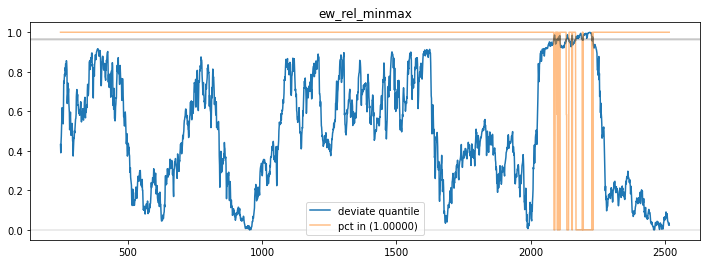

Saving mine2 params...


In [33]:
SD = 0.2213282
N_RAND = 20
N_ADJ = 180

#N_RAND = 5
#N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [34]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [35]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 5.159262393765425 (ew_ma)
  0.99999990 in
time param: 811
qs:
(0.0000 - 0.9458): 1.0000
(0.9458 - 0.9489): 0.9998
(0.9489 - 0.9618): 0.9998
(0.9618 - 1.0000): 0.0006

^IXIC:
  Best Return: 9.883761953307008 (ew_ma)
  0.99999999 in
time param: 435
qs:
(0.0000 - 0.9355): 1.0000
(0.9355 - 0.9514): 1.0000
(0.9514 - 0.9572): 0.9990
(0.9572 - 1.0000): 0.0002

^NYA:
  Best Return: 4.526799978009764 (ew_rel_minmax)
  0.99999371 in
time param: 1458
qs:
(0.0000 - 0.8064): 1.0000
(0.8064 - 0.8259): 0.9996
(0.8259 - 0.8421): 0.0002
(0.8421 - 1.0000): 0.0000

^W5000:
  Best Return: 6.3465807995207735 (ew_ma)
  1.00000000 in
time param: 755
qs:
(0.0000 - 0.9272): 1.0000
(0.9272 - 0.9358): 0.9993
(0.9358 - 0.9471): 0.0105
(0.9471 - 1.0000): 0.0001

mine1:
  Best Return: 15.139095988334374 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9565): 1.0000
(0.9565 - 0.9566): 0.9627
(0.9566 - 0.9568): 0.0996
(0.9568 - 1.0000): 0.0003

mine2:
  Best Return: 6.880106683407963 (ew

{'^GSPC': {'best_return': 5.159262393765425, 'pct_in': 0.9999999027474755},
 '^IXIC': {'best_return': 9.883761953307008, 'pct_in': 0.999999990622487},
 '^NYA': {'best_return': 4.526799978009764, 'pct_in': 0.9999937146760466},
 '^W5000': {'best_return': 6.3465807995207735, 'pct_in': 1.0},
 'mine1': {'best_return': 15.139095988334374, 'pct_in': 1.0},
 'mine2': {'best_return': 6.880106683407963, 'pct_in': 1.0}}

In [36]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = (num / den) - 1
    if weight <= 0:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 5.159262393765425,
  'pct_in': 0.9999999027474755,
  'weight': 0.29392949130848023},
 '^IXIC': {'best_return': 9.883761953307008,
  'pct_in': 0.999999990622487,
  'weight': 0.3377237406454565},
 '^NYA': {'best_return': 4.526799978009764,
  'pct_in': 0.9999937146760466,
  'weight': 0.6630397330796094},
 '^W5000': {'best_return': 6.3465807995207735,
  'pct_in': 1.0,
  'weight': 0.506417638247787},
 'mine1': {'best_return': 15.139095988334374,
  'pct_in': 1.0,
  'weight': 0.08572061128396513},
 'mine2': {'best_return': 6.880106683407963,
  'pct_in': 1.0,
  'weight': 0.19659505261206744}}

In [37]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [38]:
!say qp is dunzo